## Метод наименьших квадратов для временных рядов, поиск лучшей модели

#### Описание задачи.
Предлагается взять временные данные по коронавирусу [отсюда](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/) и проверить для разных временных отрезков, какая модель лучше подходит на разных временных отрезках и есть ли система в том, как одна лучшая модель сменяется другой с течением времени в разных географических точках.

Если такая система есть, то можно попробовать предсказать следующую модель, если в данный момент лучше подходит та или иная из них, а модели сменяют друг друга в определенном порядке.

Если в моделях одинаковое количество параметров, то сравнивать их можно по ошибке аппроксимации (минимальной сумме 
$\min\sum\limits_{i=1}^{N}(y_i - \overline{y}_i)^2)$. Однако, если параметров разное количество, то этот вариант не годится. Есть разные подходы. Но самый простой - сравнение моделей по ошибке прогноза с оцененными по МНК параметрами.

#### Исследуемые модели.

1. Полиноминальная
$$ f(x) = \sum\limits_{i=0}^{n} a_ix^{i}, \quad n \in \mathbb{N} \quad \quad \text{poly n} $$
---------------------------------------
2. Экспонициальная
$$ f(x) = a e^{bx} \quad \quad \text{исключена, так как не дала хороших результатов} $$ 
---------------------------------------
3. Показательная
$$ f(x) = a b^{x} \quad \quad \text{pos}$$
---------------------------------------
4. Логарифмическая
$$ f(x) = a + b \ln x \quad \quad \text{log}$$

#### Описание алгоритма исследования.

1. Выберем страны кандидаты для исследования, я выбрал Россию, США, Испанию, Германию.

2. Для каждой страны в отдельности разобьем весь период эпидемии на части по $n$ дней без пересечения, т.е. с $1$ по $n$, с $n+1$ по $2n$ и так далее и на каждом участке будем сравнивать введеные выше модели, обучая модель на $i$ участке и сравнивая предсказание с $i + 1$ по MSE.
3. Для каждой страны возьмем первым днем начала эпидемии, когда в стране офицально появилось 10 зараженных, ранее рассматривать не имеет смысла, так как графики не показательны.  
4. Рассмотрим полученные результаты, попробуем найти 'прослеживается' ли система смен моделей в зависимости от времени и от количества зараженных за прошедшую неделю.

### Данные взяты по 14/6/20

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.optimize import optimize, curve_fit
from functools import partial
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
filterwarnings('ignore')

In [277]:
### traings classes

class poly:
    def __init__(self, max_deg=5):
        self.max_deg = max_deg
        
    def fit(self, X, Y):
        self.best_poly_coef = np.polyfit(X, Y, self.max_deg)
        self.best_poly = np.poly1d(self.best_poly_coef)
        
    def predict(self, X):
        return [self.best_poly(x) for x in X]
    
class exp:
    def __init__(self, a=1, b=1):
        self.a, self.b = a, b
        self.f = lambda x, a, b: a * np.e ** (b * x)
        
    def fit(self, X, Y):
        popt, pcov = curve_fit(self.f, X, Y, p0 = (self.a, self.b))
        self.a, self.b = popt
        self.f = lambda x: self.a * np.e ** (self.b * x)
        
    def predict(self, X):
        return [self.f(x) for x in X]
    
class pos:
    def __init__(self, a=1, b=1):
        self.a, self.b = a, b
        self.f = lambda x, a, b: a * b ** x
        
    def fit(self, X, Y):
        popt, pcov = curve_fit(self.f, X, Y, p0 = (self.a, self.b))
        self.a, self.b = popt
        self.f = lambda x: self.a * self.b ** x
        
    def predict(self, X):
        return [self.f(x) for x in X]
    

class log:
    def __init__(self, a=1, b=1):
        self.a, self.b = a, b
        self.f = lambda x, a, b: b * np.log(x) + a
        
    def fit(self, X, Y):
        popt, pcov = curve_fit(self.f, X, Y, p0 = (self.a, self.b))
        self.a, self.b = popt
        self.f = lambda x: self.b * np.log(x) + self.a
        
    def predict(self, X):
        return [self.f(x) for x in X]

In [278]:
def read_contry(name):
    df = pd.read_csv('time_series_covid19_confirmed_global.csv')
    df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)
    df = df[df['Country/Region'] == name].to_numpy()[:, 1:][0]
    
    nonzeroday = -1
    for day, n_infection in enumerate(df):
        if n_infection > 10:
            nonzeroday = day
            break
    
    return (day, df[day:].astype('float'))


def plot_result(country_name, n_days):
    ### init data
    nonzero_day, y = read_contry(country_name)
    x = np.array([i for i in range(len(y))]).astype('float')
    
    ### split data n_days
    weeks_x = np.array_split(x, len(x) // n_days)
    weeks_y = np.array_split(y, len(y) // n_days)
    
    table = {}
    for week_x, week_y, next_week_x, next_week_y, index in zip(weeks_x, weeks_y, weeks_x[1:], weeks_y[1:], range(len(weeks_x))):
        table[index + 1], array_mse = {}, []

        # fitting poly regression
        for deg in [1, 2, 5]:
            p = poly(max_deg=deg)
            p.fit(week_x, week_y)
            y_pred, y_true = p.predict(next_week_x), next_week_y

            mse_error = mean_squared_error(y_true, y_pred)
            array_mse.append(mse_error)
            table[index + 1][f'poly {deg}'] = mse_error

    #     # fitting exp regression
    #     r = exp()
    #     r.fit(week_x, week_y)
    #     y_pred, y_true = r.predict(next_week_x), next_week_y
    #     table[index + 1]['exp'] = mean_squared_error(y_true, y_pred)

        # fitting pos regression
        r = pos()
        r.fit(week_x, week_y)
        y_pred, y_true = r.predict(next_week_x), next_week_y
        table[index + 1]['pos'] = mean_squared_error(y_true, y_pred)

        # fitting log regression
        r = log()
        r.fit(week_x, week_y)
        y_pred, y_true = r.predict(next_week_x), next_week_y
        table[index + 1]['log'] = mean_squared_error(y_true, y_pred)
    
    
    # preparing data for display
    model_scores = defaultdict(list)
    for week in table.keys():
        for model in table[week]:
            model_scores[model].append(table[week][model])
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 10))

    ax[0].set_title(f'MSE plot, {country_name}', fontsize=20)
    for model in model_scores:
        n_weeks = len(model_scores[model])
        # range(2, n_weeks + 2) — since we start to predict from the second week
        ax[0].plot([i for i in range(2, n_weeks + 2)], model_scores[model], label=model)

    ### set graphic params
    # ax[0].set_xlabel(f'Group of n_days={n_days}', fontsize=16) (double init)
    ax[0].set_ylabel('MSE error', fontsize=16)
    ax[0].set_yscale('log')
    ax[0].set_xticks(range(1, n_weeks + 2))
    ax[0].set_yticks([10 ** i for i in range(3, 10)]) # optimal settings for differentiation models
    ax[0].grid()
    ax[0].legend();


    # graphic number infected per week
    ax[1].plot([i for i in range(1, len(weeks_y) + 1)], [max(week) - min(week) for week in weeks_y])
    ax[1].set_xlabel(f'Group of n_days={n_days}', fontsize=16)
    ax[1].set_ylabel('infected per week', fontsize=16)
    ax[1].set_xticks(range(1, n_weeks + 2))
    ax[1].grid()
    
    return ax

### Графики

На первом графике отображены модели в легенде, а также по оси Ох количество дней на которых модель обучается и на какой промежуток времени предсказывает (по умолчанию это недели), по Оу представлена MSE для каждой модели, под главным графиком для удобства показано количество заразившихся за конкретную неделю.

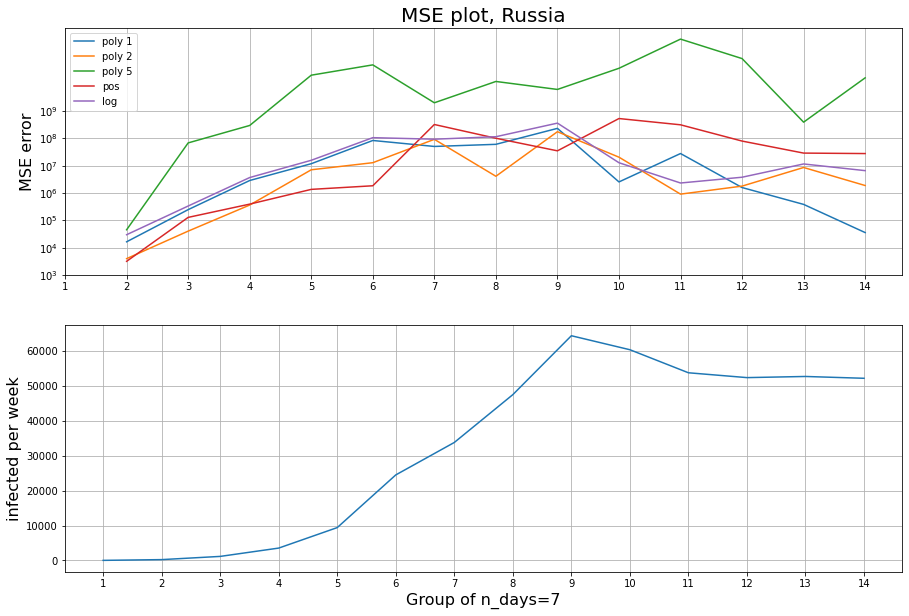

In [298]:
#countries = ['Russia', 'US', 'Spain', 'Germany']

plot_result('Russia', 7);

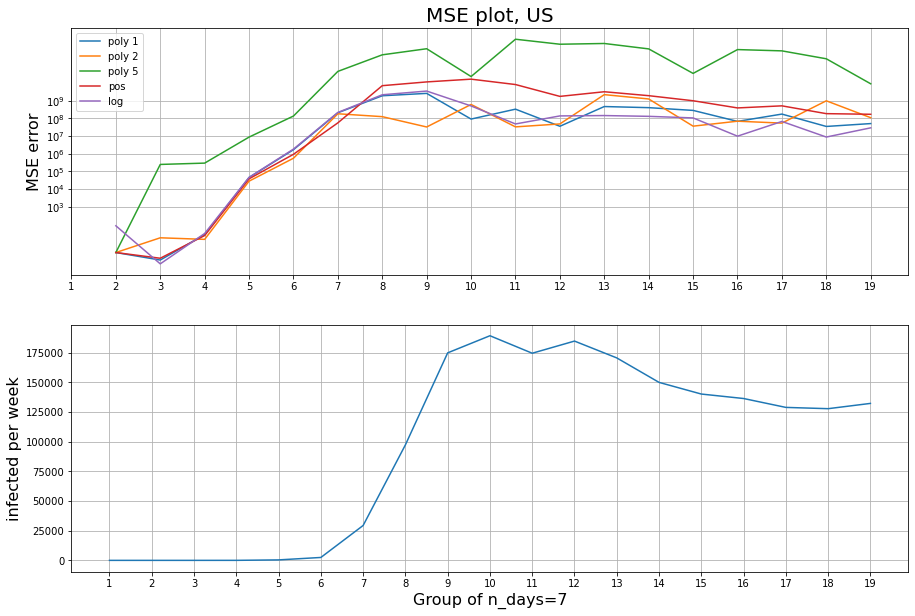

In [299]:
plot_result('US', 7);



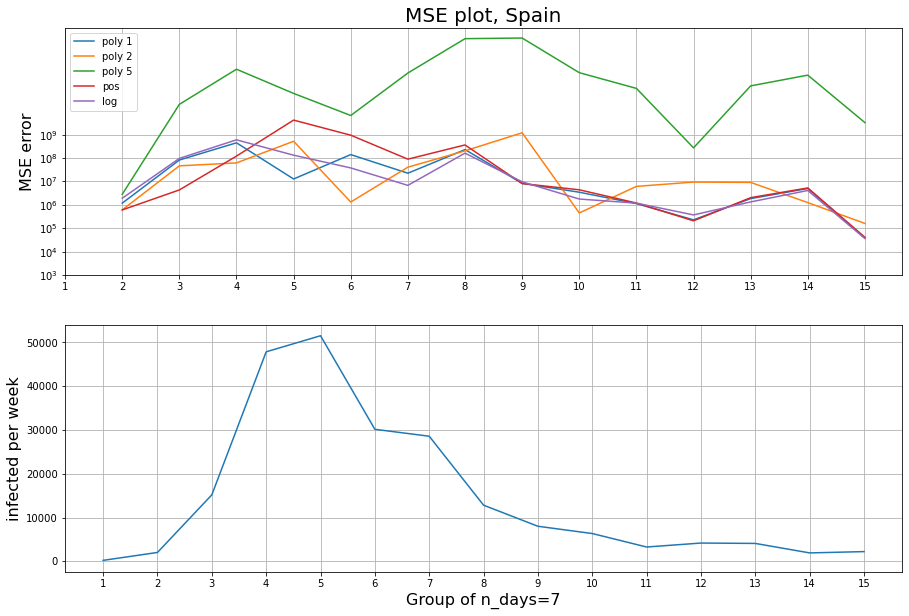

In [300]:
plot_result('Spain', 7);

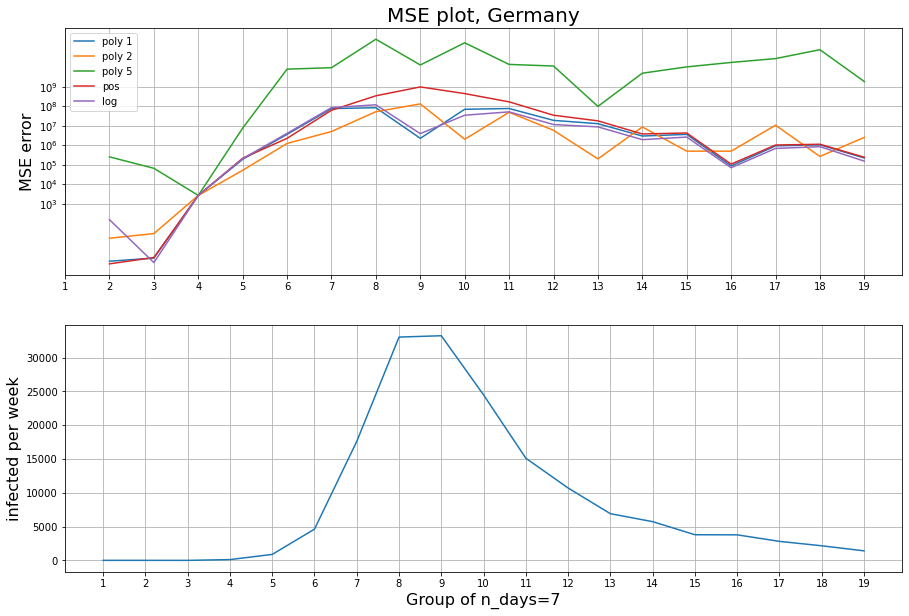

In [301]:
plot_result('Germany', 7);

### Краткие выводы

1. По графикам видно, что в среднем многочлен второй степени чаще всего лучше всего приближает количество заравших до пика.
2. Когда пик сходит, в зависимости от скорости убывания, если убывание более статичное, как в случае с Россией, подходят медленее растущие функции, как, например, линейная. Если происходит не статичное убывание, то логарифмическая функция лучше всего подходит.